In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=2)
import os
import torch
from torchvision.utils import make_grid, save_image

In [3]:
def get_gs_jacobi_time(path):
    report = np.load(os.path.join('plot_data', path, 'report.npz'))
    all_times = report['all_times']
    all_rows_ids = report['all_row_ids']
    image_width = np.max(all_rows_ids)
    ratios = (np.sum(all_rows_ids != image_width, axis=-1) + 1) / all_rows_ids.shape[-1]
    scaled_time = all_times * ratios
    return scaled_time

def get_jacobi_gs_time(path):
    report = np.load(os.path.join('plot_data', path, 'report.npz'))
    all_samples = report['all_samples']
    all_samples = all_samples.reshape((10, -1, np.prod(all_samples.shape[-4:]).astype(int)))    
    all_samples = all_samples.reshape((10, all_samples.shape[1], -1))
    true_samples = all_samples[:, -1:, :]
    diffs = np.max(np.abs(all_samples - true_samples), axis=-1)
    ratios = (np.sum(np.cumprod(diffs > 0.01, axis=-1), axis=-1) + 1) / (diffs.shape[-1])
    all_times = report['all_times']
    scaled_time = all_times * ratios
    return scaled_time

def get_jacobi_time(path):
    report = np.load(os.path.join('plot_data', path, 'report.npz'))
    all_samples = report['all_samples']
    all_samples = all_samples.reshape((10, -1, np.prod(all_samples.shape[-4:]).astype(int)))
    all_samples = all_samples.reshape((10, all_samples.shape[1], -1))
    true_samples = all_samples[:, -1:, :]
    diffs = np.max(np.abs(all_samples - true_samples), axis=-1)
    ratios = (np.sum(np.cumprod(diffs > 0.01, axis=-1), axis=-1) + 1) / (diffs.shape[-1])
    all_times = report['all_times']
    scaled_time = all_times * ratios
    return scaled_time

In [4]:
get_jacobi_time('mnist_sequential').mean()

12.154888772964478

In [5]:
get_jacobi_time('mnist_sequential_cache').mean()

8.227526879310608

In [6]:
get_jacobi_time('mnist_jacobi').mean()

1.9375384184778952

In [7]:
get_jacobi_gs_time('mnist_jacobi_gs').mean()

5.954596882511159

In [8]:
get_gs_jacobi_time('mnist_gs_jacobi').mean()

1.861929690898681

In [9]:
get_jacobi_time('cifar10_sequential').mean()

30.94778730869293

In [10]:
get_jacobi_time('cifar10_sequential_cache').mean()

17.761827898025512

In [11]:
get_jacobi_time('cifar10_jacobi').mean()

26.155026908917353

In [12]:
get_jacobi_gs_time('cifar10_jacobi_gs').mean()

14.759753727912903

In [13]:
get_gs_jacobi_time('cifar10_gs_jacobi').mean()

14.874395199050195

# Curves

In [14]:
import seaborn as sns
sns.set(font_scale=2.5)

def get_other_data(path):
    report = np.load(os.path.join('plot_data', path, 'report.npz'))
    all_samples = report['all_samples']
    all_times = report['all_times']
    true_sample = all_samples[:, -1:, ...]
    all_samples = np.pad(all_samples, ((0, 0), (1, 0), (0, 0), (0, 0),
                                      (0, 0), (0, 0)), mode='constant', constant_values=0.)
    diffs = all_samples - true_sample
    diffs = diffs.reshape((diffs.shape[0], diffs.shape[1], -1))
    diffs = np.linalg.norm(diffs, axis=-1)
    times = np.linspace(0, np.mean(all_times), all_samples.shape[1])
    return diffs, times

def get_jacobi_gs_data(path):
    report = np.load(os.path.join('plot_data', path, 'report.npz'))
    all_samples = report['all_samples']
    all_times = report['all_times']
    shape = all_samples.shape
    all_samples = all_samples.reshape((shape[0], -1, *shape[3:]))
    true_sample = all_samples[:, -1:, ...]
    all_samples = np.pad(all_samples, ((0, 0), (1, 0), (0, 0), (0, 0),
                                  (0, 0), (0, 0)), mode='constant', constant_values=0.)
    diffs = all_samples - true_sample
    diffs = diffs.reshape((diffs.shape[0], diffs.shape[1], -1))
    diffs = np.linalg.norm(diffs, axis=-1)
    times = np.linspace(0, np.mean(all_times), all_samples.shape[1])
    
    return diffs, times

def visualize_data(filename, idx=0):
    all_images = np.load(os.path.join('plot_data', filename + '_images.npz'))
    images = all_images[str(idx)][:, 0, :]
    try:
        images = images.reshape(images.shape[0], 3, 32, 32)
    except:
        images = images.reshape(images.shape[0], 1, 28, 28)
        
    sep = images.shape[0] // 10
    images = images[::sep, ...]
    images = images[None, ...].transpose(0,3,1,4,2).reshape(images.shape[-1], images.shape[0]*images.shape[-1], -1).squeeze()
    images = images / 2. + 0.5
    plt.figure()
    plt.axis('off')
    plt.grid('off')

    if len(images.shape) == 2:
        plt.imshow(images, cmap='gray')
    else:
        plt.imshow(images)
    plt.show()
    
def plot_time(diffs, times, color):
    diffs_m = np.mean(diffs, axis=0)
    std = np.std(diffs, axis=0)
    ub = diffs_m + std
    lb = diffs_m - std
    plt.plot(times, diffs_m, '-', lw=4, color=color)
    plt.fill_between(times, ub, lb, facecolor=color, alpha=0.5)
    plt.xlabel('Wall-Clock Time (s)')
    plt.ylabel('$\ell_2$ Error')
    
def plot_iter(diffs, times, color):
    diffs_m = np.mean(diffs, axis=0)
    std = np.std(diffs, axis=0)
    ub = diffs_m + std
    lb = diffs_m - std
    plt.plot(np.r_[:len(times)], diffs_m, '-', lw=4, color=color)
    plt.fill_between(np.r_[:len(times)], ub, lb, facecolor=color, alpha=0.5)
    plt.xlabel('Parallel Iterations')
    plt.ylabel('$\ell_2$ Error')

## Plot MNIST results

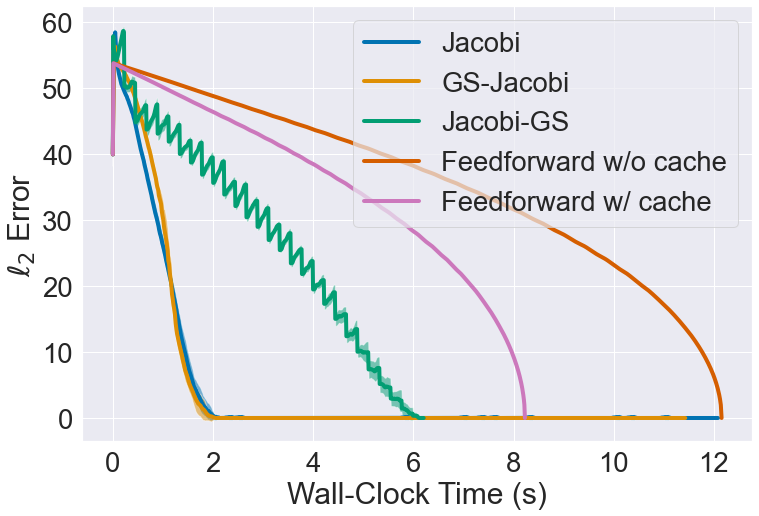

In [19]:
r, g, b, c, k, *_ = sns.color_palette('colorblind')
plt.figure(figsize=(12,8))

diffs, times = get_other_data('mnist_jacobi')
plot_time(diffs, times, r)
diffs, times = get_other_data('mnist_gs_jacobi')
plot_time(diffs, times, g)
diffs, times = get_jacobi_gs_data('mnist_jacobi_gs')
plot_time(diffs, times, b)
diffs, times = get_other_data('mnist_sequential')
plot_time(diffs, times, c)
diffs, times = get_other_data('mnist_sequential_cache')
plot_time(diffs, times, k)

plt.legend(['Jacobi', 'GS-Jacobi', 'Jacobi-GS', 'Feedforward w/o cache', 'Feedforward w/ cache'], 
           framealpha=0.7)
plt.savefig('pixelcnnpp_mnist.png', dpi=200, bbox_inches='tight')

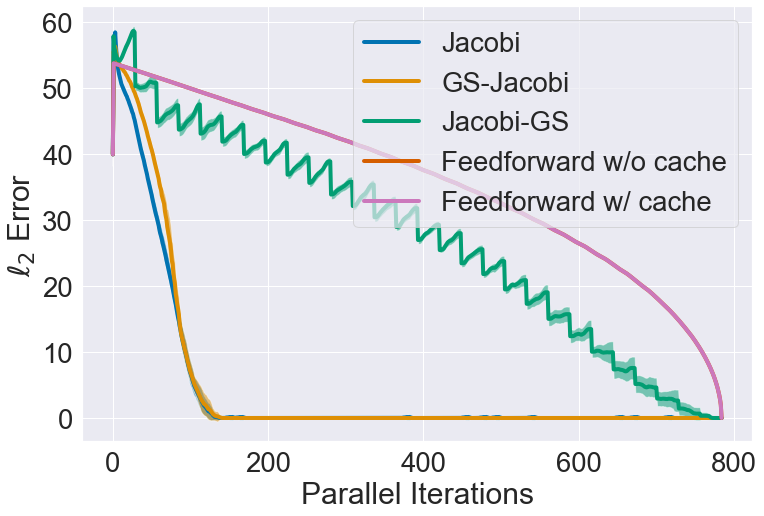

In [20]:
r, g, b, c, k, *_ = sns.color_palette('colorblind')
plt.figure(figsize=(12,8))

diffs, times = get_other_data('mnist_jacobi')
plot_iter(diffs, times, r)
diffs, times = get_other_data('mnist_gs_jacobi')
plot_iter(diffs, times, g)
diffs, times = get_jacobi_gs_data('mnist_jacobi_gs')
plot_iter(diffs, times, b)
diffs, times = get_other_data('mnist_sequential')
plot_iter(diffs, times, c)
diffs, times = get_other_data('mnist_sequential_cache')
plot_iter(diffs, times, k)

plt.legend(['Jacobi', 'GS-Jacobi', 'Jacobi-GS', 'Feedforward w/o cache', 'Feedforward w/ cache'], 
           framealpha=0.7)
plt.savefig('pixelcnnpp_mnist_iter.png', dpi=200, bbox_inches='tight')

## Plot CIFAR-10 results

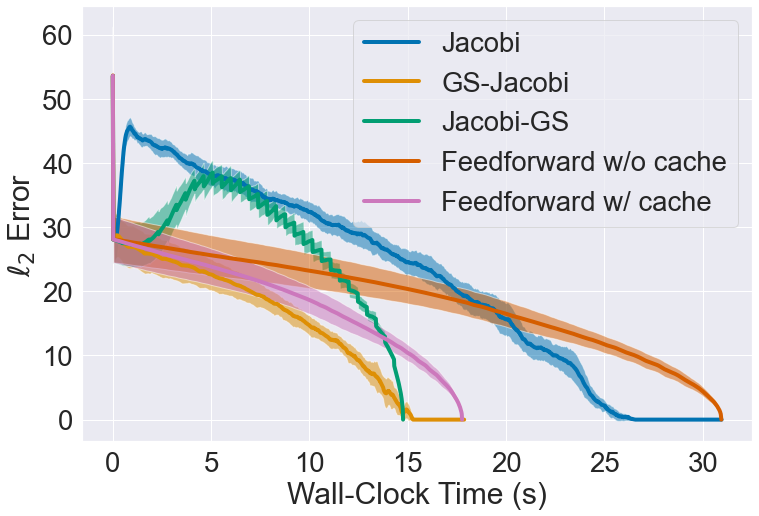

In [21]:
r, g, b, c, k, *_ = sns.color_palette('colorblind')
plt.figure(figsize=(12,8))

diffs, times = get_other_data('cifar10_jacobi')
plot_time(diffs, times, r)
diffs, times = get_other_data('cifar10_gs_jacobi')
plot_time(diffs, times, g)
diffs, times = get_jacobi_gs_data('cifar10_jacobi_gs')
plot_time(diffs, times, b)
diffs, times = get_other_data('cifar10_sequential')
plot_time(diffs, times, c)
diffs, times = get_other_data('cifar10_sequential_cache')
plot_time(diffs, times, k)

plt.legend(['Jacobi', 'GS-Jacobi', 'Jacobi-GS', 'Feedforward w/o cache', 'Feedforward w/ cache'], 
           framealpha=0.7)
plt.savefig('pixelcnnpp_cifar10.png', dpi=200, bbox_inches='tight')

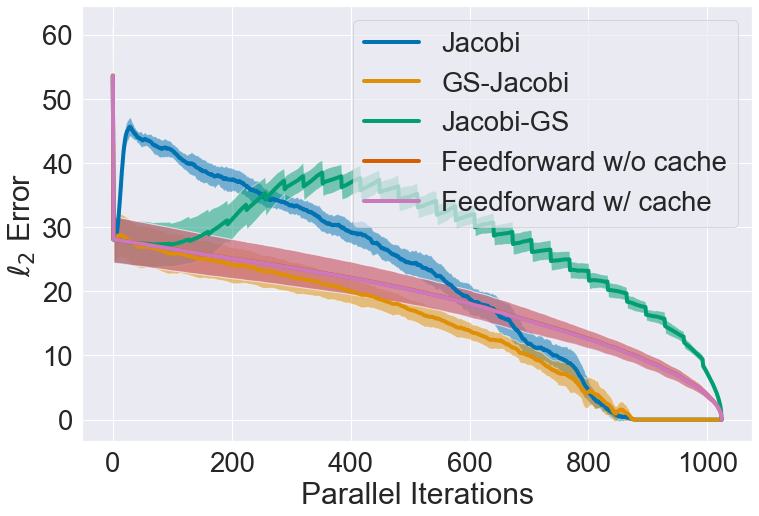

In [22]:
r, g, b, c, k, *_ = sns.color_palette('colorblind')
plt.figure(figsize=(12,8))

diffs, times = get_other_data('cifar10_jacobi')
plot_iter(diffs, times, r)
diffs, times = get_other_data('cifar10_gs_jacobi')
plot_iter(diffs, times, g)
diffs, times = get_jacobi_gs_data('cifar10_jacobi_gs')
plot_iter(diffs, times, b)
diffs, times = get_other_data('cifar10_sequential')
plot_iter(diffs, times, c)
diffs, times = get_other_data('cifar10_sequential_cache')
plot_iter(diffs, times, k)

plt.legend(['Jacobi', 'GS-Jacobi', 'Jacobi-GS', 'Feedforward w/o cache', 'Feedforward w/ cache'], 
           framealpha=0.7)
plt.savefig('pixelcnnpp_cifar10_iter.png', dpi=200, bbox_inches='tight')